In [126]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from symengine import *
from mimiqcircuits import *
from tqdm import tqdm

In [127]:
def plot_adjacency_matrix(adj_matrix, title="Adjacency Matrix"):
    plt.figure(figsize=(6,6))
    
    plt.imshow(adj_matrix, cmap='gray_r', interpolation='none')
    plt.title(title)
    plt.colorbar(label="Edge Weight")
    plt.show()

In [128]:
n=3
np.random.seed(1234)

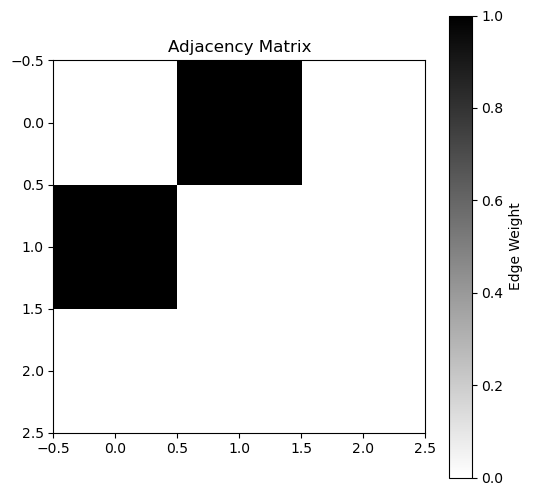

In [129]:
A = np.triu(np.random.randint(0, 2, (n, n)), 1)
D=A+A.T
plot_adjacency_matrix(D)

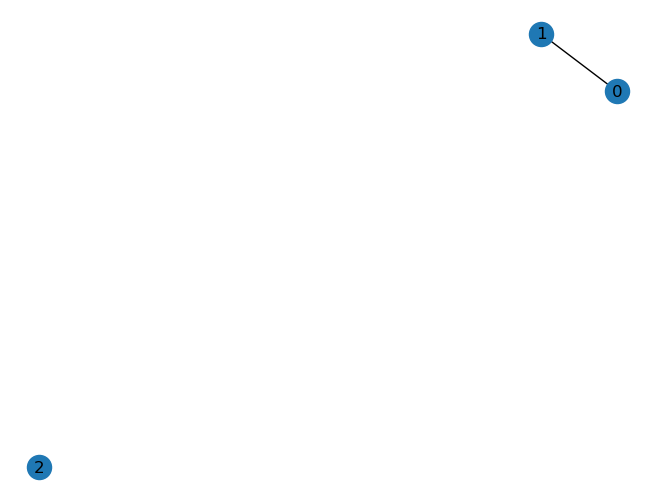

In [130]:
G = nx.Graph(D)
nx.draw(G, with_labels=True)

In [ ]:
def cost(X,A):
    c=np.sum(A,axis=0)
    return -X.T @ A @ X+c.T @ X

In [132]:
connect = MimiqConnection(url="https://mimiq.qperfect.io/api")
connect.connect("marco.vassallo02@gmail.com","Eucalipto03")

Connection:
├── url: https://mimiq.qperfect.io/api
├── Computing time: 199/3000 minutes
├── Max time limit per request: 180 minutes
├── Default time limit is equal to max time limit: 180 minutes
└── status: open

In [ ]:
def Build_QAOA(B, q, draw=False):
    beta=[symbols(f"beta_{i}") for i in range(q)]
    gamma=[symbols(f"gamma_{i}") for i in range(q)]
    n=len(B) #Qubit number

    c=Circuit() #Circuit definition
    c.push(GateH(), range(0, n))
        
    for k in tqdm(range(0,q), desc="Building QAOA Layers"):

        #Block here
        for i in range(0,n) :
            for j in range(i+1,n):
                A_ij = B[i,j]
                if A_ij != 0:
                    c.push(GateRZZ(gamma[k]*A_ij), i, j)    #The Upeer one is ALWAYS the control one

        #Block Here
        
        c.push(GateRX(beta[k]), range(0,n))
        
    if draw:
        c.draw()

    return c

In [134]:
def Run_QAOA(circuit, beta, gamma, connect):
   dict_beta={f"beta_{i}":beta[i] for i in range(len(beta))}
   dict_gamma={f"gamma_{i}":gamma[i] for i in range(len(gamma))}
   full_dict = {**dict_beta, **dict_gamma}
   ev_circ = circuit.evaluate(full_dict)
   job_id = connect.execute(ev_circ)
   res = connect.get_result(job_id)
   print(res)
   return res

In [135]:
def Optimizer(circuit,Beta_best,Gamma_best,iteration): 
    Cost_best= 0
    for i in tqdm(range(iteration), desc="outer one"):
        Cost=0
        beta = Beta_best + np.random.normal(0,0.2)
        gamma = Gamma_best + np.random.normal(0,0.2)
        state_vector = Run_QAOA(circuit,beta,gamma,connect).histogram()
        for state, measures in tqdm( state_vector.items(), desc="inner one"):
            state=np.array(state.tolist())
            Cost+=cost(state,D)*measures
        if(Cost>Cost_best):
            Cost_best=Cost
            Beta_best=beta
            Gamma_best=gamma
        if(i==iteration-1):
            return max(state_vector, key=state_vector.get)
    return 0

In [136]:
iteration=1
layer_number = 1
circuit = Build_QAOA(D, layer_number)


beta = np.random.uniform(0, np.pi, layer_number)
gamma = np.random.uniform(0, np.pi, layer_number)
val=Optimizer(circuit,beta,gamma,iteration)

outer one:   0%|          | 0/1 [00:00<?, ?it/s]

QCSResults:
├── simulator: MIMIQ-StateVector 0.18.2
├── timings:
│    ├── total time: 0.000600419s
│    ├── sample time: 0.000102348s
│    ├── parse time: 0.000173804s
│    ├── apply time: 5.6926e-05s
│    └── compression time: 0.000117797s
├── fidelity estimate: 1
├── average multi-qubit gate error estimate: 0
├── most sampled:
│    ├── bs"000" => 203
│    ├── bs"001" => 197
│    ├── bs"110" => 171
│    ├── bs"111" => 168
│    └── bs"010" => 78
├── 1 executions
├── 0 amplitudes
└── 1000 samples


outer one:   0%|          | 0/1 [00:02<?, ?it/s]


In [137]:
print(val)
circuit.draw()

frozenbitarray('000')
        ┌─┐      ┌──────────────┐  ┌──────────┐                                 
 q[0]: ╶┤H├──────┤0             ├──┤RX(beta_0)├────────────────────────────────╴
        └─┘┌─┐   │  RZZ(gamma_0)│  └──────────┘┌──────────┐                     
 q[1]: ╶───┤H├───┤1             ├──────────────┤RX(beta_0)├────────────────────╴
           └─┘┌─┐└──────────────┘              └──────────┘┌──────────┐         
 q[2]: ╶──────┤H├──────────────────────────────────────────┤RX(beta_0)├────────╴
              └─┘                                          └──────────┘         
                                                                                
